In [1]:
#Imported directly from kaggle
import pandas as pd

df = pd.read_csv("/kaggle/input/recipes/dataset/full_dataset.csv")

In [2]:
#Select the column i'm interested in for clustering 

colNER = df['NER']
size = len(colNER)

In [3]:
#Subsampling for computability reason

import random

subsample_size = len(colNER) // 500

colNER_subsample = colNER.sample(n=subsample_size, random_state=42)

colNER_subsample = colNER_subsample.reset_index(drop=True)

Attempted vectorization and subsequent clustering of documents with tf-idf. The purpose is to divide the documents by ingradients, so I will use the NER column for the various clusters.

I used tf-idf although the ingredients within a single recipe do not repeat in the “NER” field. Later I will develop a mechanism better suited to this situation, using this method as the “base case”.

To create the vectorization documents, I simply concatenated all the ingredients in NER into a single string.

In [4]:
#Create vector from element in the column

import ast

def NER_to_list_str(list_NER):
    list_of_string = []
    for item in list_NER:
        toStr = ' '.join(ast.literal_eval(item))
        list_of_string.append(toStr)
    return list_of_string

list_of_string = NER_to_list_str(colNER_subsample)

In [5]:
#vectorizer with all data 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

vectorizer.fit(NER_to_list_str(colNER))

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [6]:
import random
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}\n")
sorted(random.sample(vocab.tolist(),10))

Length of vocabulary: 8727



['ear',
 'men',
 'nestl',
 'nonstick',
 'packagealouette',
 'pumkin',
 'satoimo',
 'sparking',
 'squares',
 'unflavored']

In [26]:
vector_documents = vectorizer.transform(list_of_string)

After performing vectorization we try to define clusters. Since we do not have a number of clusters available, we should use a method to identify it.

**K-Means**

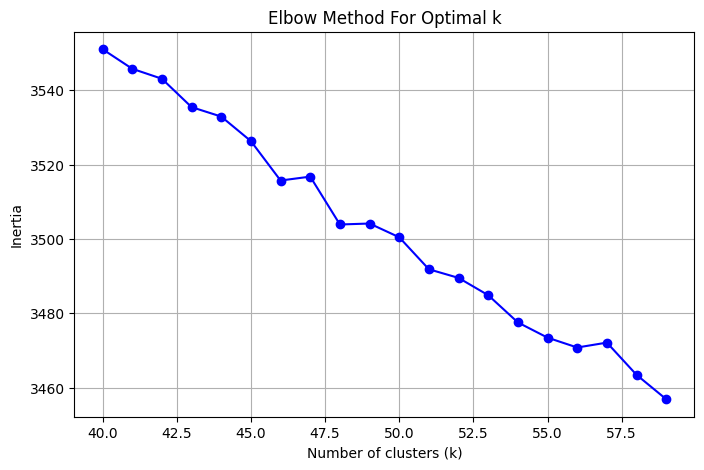

In [27]:
#Try to find k with elbow

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertia = []  
K = range(40, 60)  

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(vector_documents)
    inertia.append(kmeans.inertia_) 

# Plot
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()


The graph does not mark a particular “elbow” point to be considered as the optimal number of clusters. Let us try another method.

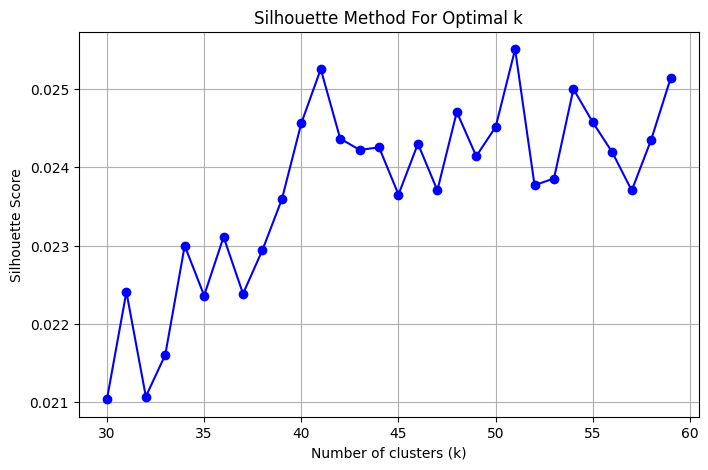

In [28]:
#Try to find k with silhoutte 

from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(30, 60)  

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(vector_documents)
    score = silhouette_score(vector_documents, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette
plt.figure(figsize=(8,5))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.grid(True)
plt.show()


Tried different situations, in particular I alternated vectorization in which words to be considered actually must be rpesent in at least 10000 rows, than in 5 rows. Always giving different results. 

In the former the optimal number of clusters was around 30, in the latter even 60. Not finding a way on how to progress the analysis. 

Below is an attempt with 30 clusters

In [12]:
#Different subsample extraction

subsamples = []
dim = 200
print(f"Number of element for subsample: {len(colNER) // dim}. Total element: {len(colNER)}")

for i in range(10):

    subsample_size = len(colNER) // dim
    
    colNER_subsample = colNER.sample(n=subsample_size, random_state=42+i)
    
    colNER_subsample = colNER_subsample.reset_index(drop=True)

    subsamples.append(colNER_subsample)

Number of element for subsample: 11155. Total element: 2231142


In [13]:
#Vectorization 

subsamples_data = []

for i in subsamples:
    l = NER_to_list_str(i)
    subsamples_data.append(vectorizer.transform(l))

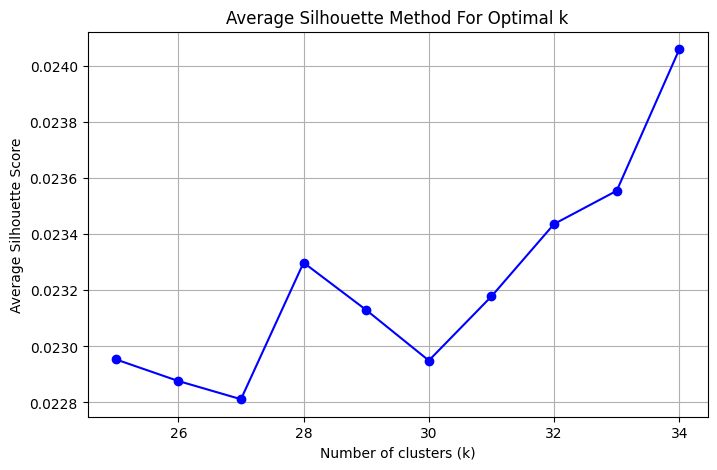

In [31]:
#silouette
import numpy as np

all_silhouette_scores = []

# Loop over each subsample
for idx, vector_documents in enumerate(subsamples_data):
    silhouette_scores = []
    K = range(25, 35)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42+idx, n_init='auto')
        kmeans.fit(vector_documents)
        score = silhouette_score(vector_documents, kmeans.labels_)
        silhouette_scores.append(score)

    all_silhouette_scores.append(silhouette_scores)

average_silhouette_scores = np.mean(all_silhouette_scores, axis=0)

# Plot the average silhouette score
plt.figure(figsize=(8,5))
plt.plot(K, average_silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Method For Optimal k')
plt.grid(True)
plt.show()

/tmp/ipykernel_435/3277610758.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=10, cmap='viridis')


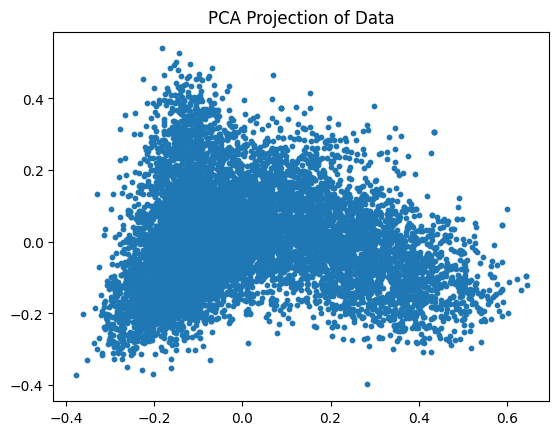

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(subsamples_data[3].toarray())  # Convert sparse to dense

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=10, cmap='viridis')
plt.title('PCA Projection of Data')
plt.show()

There seem to be two areas, more or less

In [33]:
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.decomposition import PCA

# Apply PCA to reduce data to 3 dimensions
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(subsamples_data[3].toarray())  # Convert sparse to dense if needed

# Create the 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=reduced_data[:, 0],
    y=reduced_data[:, 1],
    z=reduced_data[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=reduced_data[:, 0],  # Color by the first principal component
        colorscale='Viridis',  # Color scale
        opacity=0.8
    )
)

layout = go.Layout(
    title="3D PCA Projection of Data",
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot in Kaggle notebook
iplot(fig)


Not paricularly interesting. Let's try training k-means with 30 clusters and see what happens

In [7]:
kmeans = KMeans(n_clusters=30, random_state=42, n_init='auto')
vectorized =  vectorizer.transform(NER_to_list_str(colNER_subsample))
kmeans.fit(vectorized.toarray()) 

NameError: name 'KMeans' is not defined

In [ ]:
titles = df["title"]
items = NER_to_list_str(colNER[:100])
itemsVec = vectorizer.transform(items)

predictions = kmeans.predict(itemsVec.toarray())
clustered_documents = {i: [] for i in range(30)}

for idx, label in enumerate(predictions):
    clustered_documents[label].append(titles[idx])

for cluster_label, documents in clustered_documents.items():
    print(f"\nCluster {cluster_label}:")
    for i, doc in enumerate(documents):  
        print(f"Sample {i+1}: {doc}")
    print("\n" + "-"*50) 

This works rather poorly. Try to reduce the dimension with pca

**PCA**

In [8]:
from sklearn.decomposition import PCA
import numpy as np
optimal_components = 0

X = vectorizer.transform(NER_to_list_str(colNER_subsample))
X_dense = X.toarray()

pca = PCA()
pca.fit(X_dense)

# cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Print the first 10 variance, the purpose is the select the most significant
print("\nTop 10 variances:")
print(cumulative_variance[:10])

threshold = 0.95
optimal_components = np.argmax(cumulative_variance >= threshold) + 1   #851 first result


Top 10 variances:
[0.03706703 0.05676606 0.07251371 0.08452039 0.09598621 0.10675728
 0.11737428 0.12785583 0.13729854 0.14660722]



Number of optimal components for 0.95 threshold: 871


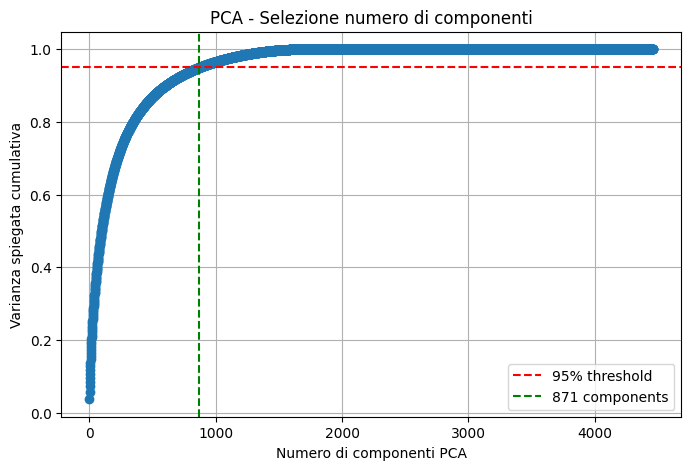

In [9]:
import matplotlib.pyplot as plt

print(f"\nNumber of optimal components for {threshold} threshold:", optimal_components)

# Facciamo il plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=threshold, color='r', linestyle='--', label=f"{int(threshold*100)}% threshold")
plt.axvline(x=optimal_components, color='g', linestyle='--', label=f"{optimal_components} components")
plt.xlabel('Numero di componenti PCA')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('PCA - Selezione numero di componenti')
plt.legend()
plt.grid(True)
plt.show()

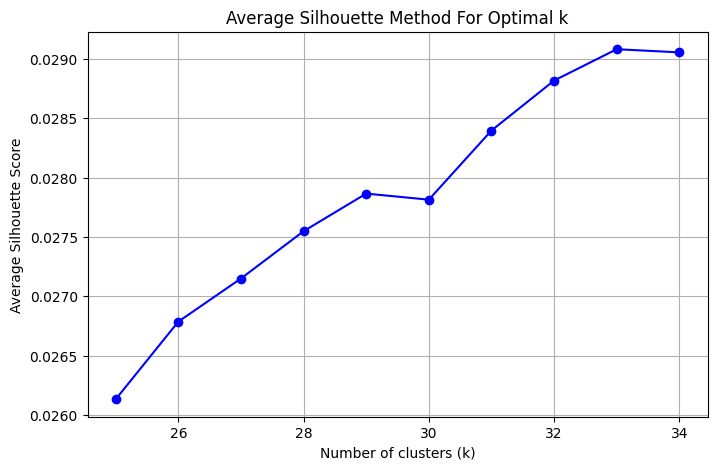

In [16]:
#Now we have the optimal component... I hope. Make k-means
#try again the kmeans, copy the same code above
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#silouette
import numpy as np

pca = PCA(n_components=optimal_components, random_state=42)

all_silhouette_scores = []

# Loop over each subsample
for idx, vector_documents in enumerate(subsamples_data):
    silhouette_scores = []
    vector_documents_reduced = pca.fit_transform(vector_documents.toarray())
    K = range(25, 35)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42+idx, n_init='auto')
        kmeans.fit(vector_documents_reduced)
        score = silhouette_score(vector_documents_reduced, kmeans.labels_)
        silhouette_scores.append(score)

    all_silhouette_scores.append(silhouette_scores)

average_silhouette_scores = np.mean(all_silhouette_scores, axis=0)

# Plot the average silhouette score
plt.figure(figsize=(8,5))
plt.plot(K, average_silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Method For Optimal k')
plt.grid(True)
plt.show()

Again in discouraging result from the point of view of the number of clusters